###### World Temperature

In [1]:
%matplotlib inline
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy import stats
from math import *
from util import *

plt.rcParams["figure.figsize"] = (8, 6)
palette = sns.color_palette()

## Parseo de datos

In [2]:
df = pd.read_csv('data/worldTemperature.csv')
fechas = list(df['year'])
temps = list(df['temp'])

# ECM vs Grado de polinomio

(0.13231904018740376, 30)


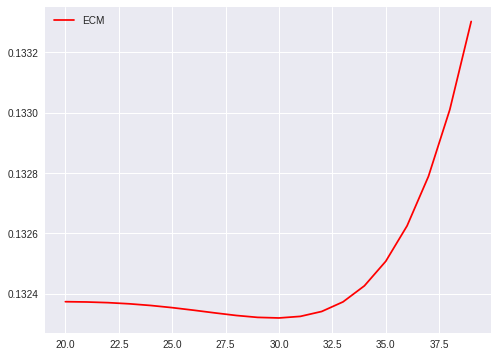

In [3]:
ecms = []

grados = range(20, 40, 1)
for grado in grados:
    f = cml(poly(grado), fechas, temps)
    results = list(map(f, fechas))
    ecms.append(ecm(results, temps))
    
m = min(zip(ecms, grados), key=lambda x: x[0])
print(m)

plt.plot(grados, ecms, 'r', label='ECM')
#plt.plot(fechas, results, 'r', label='CML')
plt.legend()

## Mido cuando comienza el calentamiento global

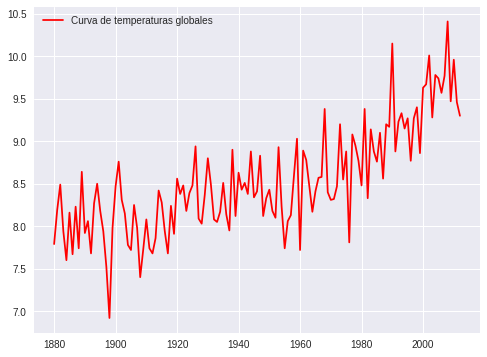

In [4]:
plt.plot(fechas, temps, 'r', label='Curva de temperaturas globales')
plt.legend()
plt.show()

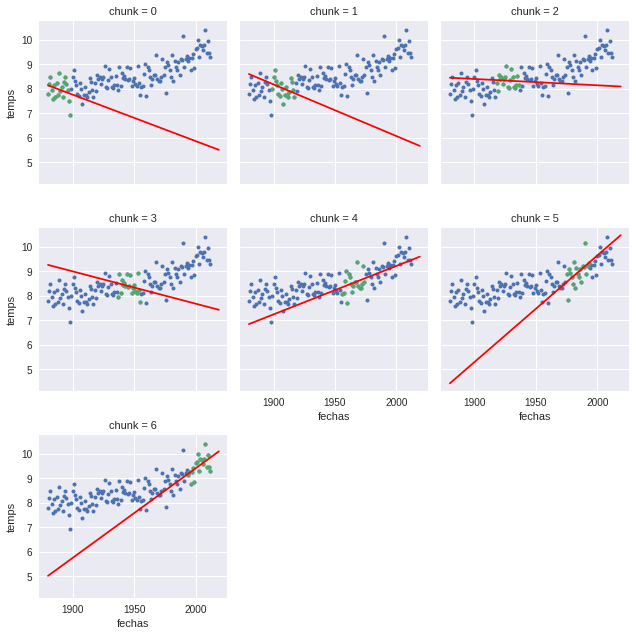

In [5]:
#Parto en 7 chuncks de 20 años (aprox) y veo las pendientes
fechasChunk = np.array_split(fechas,7)
tempChunk = np.array_split(temps,7)

fechasMasRango = fechas + list(range(2013,2020))

data = []
for c in range(7):
    f = cml(poly(1), fechasChunk[c], tempChunk[c])
    results = list(map(f, fechasMasRango))
    data.append([results, c])

df3 = pd.DataFrame(data, columns=['x', 'chunk'])

def pp(x, y, data, **kwargs):
    c = data['chunk'].values[0]
    plt.plot(fechas, temps, 'o', label='Temperatura', markersize=4)
    plt.plot(fechasChunk[c], tempChunk[c], 'o', label='Training', markersize=4)
    plt.plot(fechasMasRango, data['x'].values[0], 'r', label='CML')
    plt.legend()

l = sns.FacetGrid(df3, col="chunk", col_wrap = 3)
l.map_dataframe(pp, 'fechas', 'temps')

error year <= 1900.0 -> 0.2296080499354467
error year <= 1930.0 -> 0.0857852659628513
error year <= 1960.0 -> -0.0029193972944430158


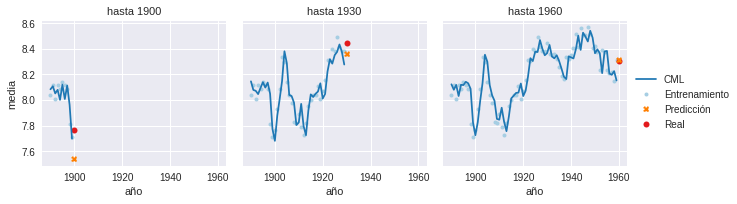

In [6]:
from functools import reduce
palette = sns.color_palette('Paired', 12)
#sns.palplot(palette)
k = 5  # cantidad de valores anteriores para AR. el df arranca en 1880+k
df = pd.read_csv('data/worldTemperature.csv')
df['rolling'] = df.rolling(5)['temp'].mean()
df = colapsarK(df, 'rolling', k, drop=False).drop(df.index[:10])

chunks = 3 # chamuyo para que FacetGrid tenga algo q facetar, no se usa
mult = ceil(len(df)/chunks)
df['chunk'] = reduce(lambda l, i: l + [i]*mult, range(chunks), [])[:len(df)]
df['chunk'] = df['chunk'].apply(lambda c: 1900 + c*30)

nameCols = ['year'] + ['prev'+str(i) for i in range(1, k+1)]

def pp(x, y, data, **kwargs):
    chunk = data.iloc[0]['chunk']
    df_training = df[df['year'] < chunk]
    test = df[df['year'] == chunk]
    
    xs = df_training[nameCols].as_matrix()
    f = cml(lambda x: [1, x[1], x[2], x[3], x[4], x[5]], xs, df_training['rolling'])
    #xs = df_training['year'].as_matrix()
    #f = cml(poly(5), xs, df_training['rolling'])
    
    results_training = list(map(f, xs))
    results_test = f(test[nameCols].as_matrix()[0])
    
    plt.plot(df_training['year'], df_training['rolling'], 'o', label='Entrenamiento', markersize=4, color=palette[0])
    plt.plot(test['year'], test['rolling'], 'o', label='Real', markersize=6, color=palette[5])

    plt.plot(df_training['year'], results_training, 'r', label='CML', color=palette[1])
    plt.plot(test['year'], results_test, 'X', label='Predicción', markersize=6, color=palette[7])
    
    #plt.legend()
    err = test.iloc[0]['rolling'] - results_test
    print('error year <= {} -> {}'.format(chunk, err))

l = sns.FacetGrid(df, col='chunk', col_wrap=3, size=3)
l.map_dataframe(pp, 'year', 'rolling')\
    .set_titles('hasta {col_name}')\
    .set_xlabels('año')\
    .set_ylabels('media')
l.add_legend()
#plt.savefig("img/world_temp_cross.png", dpi=200)

In [7]:
df = pd.read_csv('data/worldTemperature.csv')
df['rolling'] = df.rolling(5)['temp'].mean()
df = colapsarK(df, 'rolling', k, drop=False).drop(df.index[:10])
errs = []
def calc(chunk):
    df_training = df[df['year'] < chunk]
    test = df[df['year'] == chunk]
    
    xs = df_training[nameCols].as_matrix()
    f = cml(lambda x: [1, x[1], x[2], x[3], x[4], x[5]], xs, df_training['rolling'])
    #xs = df_training['year'].as_matrix()
    #f = cml(poly(5), xs, df_training['rolling'])
    
    results_training = list(map(f, xs))
    results_test = f(test[nameCols].as_matrix()[0])
    #results_test = f(test['year'].as_matrix()[0])
    
    err = (test.iloc[0]['rolling'] - results_test)**2
    global errs
    errs.append(err)
    #print('error year <= {} -> {}'.format(chunk, err))
    
for x in range(1900, 2010 + 1): calc(x)

In [12]:
min(errs)

8.5228805628012006e-06

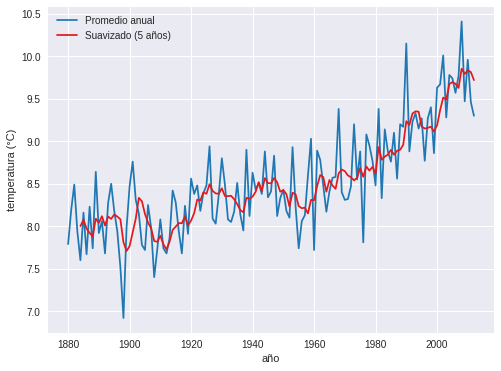

In [10]:
palette = sns.color_palette('Paired')
df = pd.read_csv('data/worldTemperature.csv')
df['rolling'] = df.rolling(5)['temp'].mean()

plt.plot(df['year'], df['temp'], 'r', label='Promedio anual', color=palette[1])
plt.plot(df['year'], df['rolling'], 'r', label='Suavizado (5 años)', color=palette[5])
plt.xlabel('año')
plt.ylabel('temperatura (°C)')
plt.legend()
plt.savefig('world_temp.png', dpi=300, bbox_inches='tight')

## Correlacion entre la temperatura y las anteriores

           year      temp     prev1     prev2     prev3     prev4     prev5
year   1.000000  0.766168  0.767760  0.764348  0.749474  0.741620  0.739919
temp   0.766168  1.000000  0.659584  0.664517  0.602701  0.654756  0.653106
prev1  0.767760  0.659584  1.000000  0.657962  0.655020  0.597261  0.659152
prev2  0.764348  0.664517  0.657962  1.000000  0.648508  0.649566  0.592506
prev3  0.749474  0.602701  0.655020  0.648508  1.000000  0.639200  0.627355
prev4  0.741620  0.654756  0.597261  0.649566  0.639200  1.000000  0.632075
prev5  0.739919  0.653106  0.659152  0.592506  0.627355  0.632075  1.000000


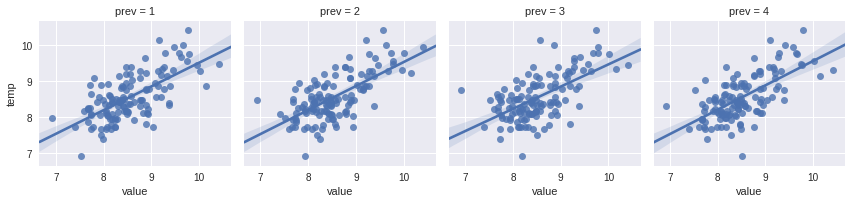

In [11]:
df = pd.read_csv('data/worldTemperature.csv')
df = colapsarK(df, 'temp', 5)
cols = ['prev{}'.format(i+1) for i in range(4)]
print(df.corr())
df = pd.melt(df, id_vars=['year', 'temp'], value_vars=cols)
df['prev'] = df['variable'].apply(lambda x: int(x[4:]))
df = df.sort_values(['year', 'prev'])
sns.lmplot(data=df, x='value', y='temp', col='prev', col_wrap=4, size=3)